## Match high attention values with secondary structure 

In [1]:
%load_ext autoreload
%autoreload 2

from collections import Counter
import os
from multiprocessing import cpu_count
import yaml

import h5py
import numexpr
import numpy as np
import pandas as pd
import scipy as sci
import scipy.signal as signal
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas(desc='Pandas op')


from scripts.general import analysis, attribution, data, util


MAX_PROC = cpu_count() - 2
numexpr.set_num_threads(MAX_PROC)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 14

### Load seq and secondary structure data

In [2]:
exp_dir = '.'

In [3]:
with open('experiment_config.yaml', 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)
    
seq_data = data.load_seq_and_abundance_data(config)[
    ['swissprot_ac', 'seq', 'Median_molecules_per_cell']
]
seq_data = seq_data.assign(
    seq_len = seq_data['seq'].str.len(),
    abundance_bin = pd.qcut(seq_data['Median_molecules_per_cell'], q = 10, labels=range(1, 11))
)
seq_data = (
    seq_data
    .sort_values('swissprot_ac')
    .assign(prot_idx = np.arange(seq_data.shape[0]))
)

In [4]:
RECOMPUTE_DSSP_ANNOT = False  # Takes some time


if RECOMPUTE_DSSP_ANNOT:
    seq_data = data.load_seq_and_abundance_data(config)[
        ['swissprot_ac', 'seq', 'Systematic_Name', 'Standard_Name', 'Median_molecules_per_cell']
    ]
    seq_data = seq_data.assign(seq_len = seq_data['seq'].str.len())

    pdb_dir = Path('../../data/pdb_yeast/pdb_files_alphafold')

    structures = seq_data[['swissprot_ac', 'seq_len']].assign(
        struct = seq_data.progress_apply(
            lambda row: data.get_dssp_annotation(pdb_dir / f"AF-{row['swissprot_ac']}-F1-model_v2.pdb",
                                                 row['seq_len']),
            axis='columns'
        )
    )

    structures = structures[structures['struct'].notnull()]
    structures.to_csv('secondary_structures.csv.gz', compression='gzip', index=False)


else:
    structures = pd.read_csv('secondary_structures.csv.gz')

In [5]:
print('N. structures', structures['swissprot_ac'].unique().shape[0])

N. structures 4745


In [6]:
struct_descr = pd.DataFrame.from_records(
    [('G', '3-turn helix'),
    ('H', '4-turn helix (α helix)'),
    ('I', '5-turn helix (π helix)'),
    ('T', 'hydrogen bonded turn (3, 4 or 5 turn)'),
    ('E', 'extended strand in parallel and/or anti-parallel β-sheet'),
    ('B', 'residue in isolated β-bridge'),
    ('S', 'bend'),
    ('-', 'coil')],
    columns = ['struct', 'descr']
)

### Get background structure counts

In [7]:
seq_data_with_struct = seq_data.merge(
    structures[['swissprot_ac', 'struct']],
    on = 'swissprot_ac'
)

background_struct_counts = seq_data_with_struct['struct'].map(Counter).sum()

background_struct_counts = pd.DataFrame.from_records(list(background_struct_counts.items()), 
                                                        columns=['struct', 'background_count'])

background_struct_counts = background_struct_counts.assign(
    mean_background_count = background_struct_counts['background_count'] / seq_data_with_struct['seq'].count(),
    background_fract = background_struct_counts['background_count'] / background_struct_counts['background_count'].sum()
).sort_values('struct')

In [8]:
seq_data_with_struct.head(1).transpose()

,0
swissprot_ac,A2P2R3
seq,MCGIFGYCNFLIEKTRGEIIDTLIEGLQALEYKEYDSSGISIQGDE...
Median_molecules_per_cell,16168.0
seq_len,262
abundance_bin,10
prot_idx,0
struct,--EEEEEEE-SS-EEHHHHHHHHHHHHHHT-SS--SEEEEEEE-SS...


### Count structures in significant positions

In [9]:
ZSCORE_CUTOFF = 1


def get_significant_struct_count(seq: str, profile: np.ndarray) -> pd.DataFrame:
    """Thin wrapper to adapt the generic letter counting function"""
    letter_counts =  analysis.get_significant_aa_count(seq, 
                                                       stats.zscore(profile),
                                                       zscore_cutoff = ZSCORE_CUTOFF)
    return letter_counts.rename(columns={'aa': 'struct'})


def struct_counts(row):
    """
    Return counts of secondary structures at positions with attention z-scores > ZSCORE_CUTOFF,
    a count for each attention profile.
    """
    attention_profiles, _ = attribution.load_profiles(row['swissprot_ac'],
                                                      attention_dir=exp_dir)
    attention_profiles = attention_profiles.tolist()
    
    struct_counts = list(map(
        lambda i: 
            get_significant_struct_count(row['seq'], 
                                         attention_profiles[i]).assign(profile_idx = i),
        range(len(attention_profiles))
    ))
    
    return pd.concat(struct_counts, ignore_index=True).assign(swissprot_ac = row['swissprot_ac'])


# TEST
# pd.concat(
#     seq_data_with_struct.head(1).apply(struct_counts, axis='columns').values,
#     ignore_index = True
# )


struct_counts = pd.concat(
    seq_data_with_struct.progress_apply(struct_counts, axis='columns').values,
    ignore_index = True
)

Pandas op:   0%|          | 0/4760 [00:00<?, ?it/s]

In [10]:
MIN_COUNT = 10  # Rule out small counts


observed_and_expected_counts = pd.merge(
    struct_counts.query('count > @MIN_COUNT'),
    background_struct_counts,
    on = 'struct'
)

observed_and_expected_counts.head(2)

,struct,count,profile_idx,swissprot_ac,background_count,mean_background_count,background_fract
0,S,14,0,A2P2R3,131682,27.664286,0.064345
1,S,15,0,D6VTK4,131682,27.664286,0.064345


In [11]:
struct_signif_test = (
    observed_and_expected_counts
    .rename(columns={'struct': 'aa'})
    .groupby(['swissprot_ac', 'profile_idx'])
    
    .progress_apply(analysis.hypergeom_test_aa_counts)
    
    .reset_index().drop(columns='level_2')
    .rename(columns={'aa': 'struct'})
)

Pandas op:   0%|          | 0/11377 [00:00<?, ?it/s]

In [12]:
enriched_struct = struct_signif_test.query('pval_over < 0.05')
depleted_struct = struct_signif_test.query('pval_under < 0.05')

In [13]:
enriched_struct.head(6)

,swissprot_ac,profile_idx,struct,pval_under,pval_over
7,D6VTK4,0,T,0.995655,9.634695e-03
8,D6VTK4,1,S,1.000000,4.210883e-08
11,D6VTK4,2,I,0.999997,1.899547e-05
14,D6W196,1,S,0.999996,1.551433e-05
17,O13297,1,S,0.994643,9.705871e-03
19,O13297,1,I,0.999874,5.117201e-04


In [14]:
enriched_struct['swissprot_ac'].unique().shape[0]

2600

In [15]:
depleted_struct['swissprot_ac'].unique().shape[0]

2558

In [16]:
len(set(enriched_struct['swissprot_ac']).intersection(depleted_struct['swissprot_ac']))

2547

### Summarize across proteins

In [17]:
enriched_struct_count = (
    enriched_struct.groupby('struct')['swissprot_ac'].count()
#     .apply(
#         lambda grp_df: pd.DataFrame.from_records(
#             list(Counter(grp_df['struct']).items()),
#             columns = ['struct', 'n_profiles_where_signif']
#         )
#     )
    .reset_index()
    .rename(columns={'swissprot_ac': 'n_proteins'})
#     .drop(columns = 'level_1')
)

enriched_struct_count.merge(struct_descr)

,struct,n_proteins,descr
0,E,157,extended strand in parallel and/or anti-parall...
1,G,1336,3-turn helix
2,I,1425,5-turn helix (π helix)
3,S,1676,bend
4,T,505,"hydrogen bonded turn (3, 4 or 5 turn)"


In [18]:
depleted_struct_count = (
    depleted_struct.groupby('struct')['swissprot_ac'].count()
#     .apply(
#         lambda grp_df: pd.DataFrame.from_records(
#             list(Counter(grp_df['struct']).items()),
#             columns = ['struct', 'n_profiles_where_signif']
#         )
#     )
    .reset_index()
    .rename(columns={'swissprot_ac': 'n_proteins'})
#     .drop(columns = 'level_1')
)

depleted_struct_count.merge(struct_descr)

,struct,n_proteins,descr
0,E,3254,extended strand in parallel and/or anti-parall...
1,G,104,3-turn helix
2,H,8,4-turn helix (α helix)
3,S,315,bend
4,T,754,"hydrogen bonded turn (3, 4 or 5 turn)"


In [19]:
struct_colors = {
    '-': 'black',
    'B': 'green',
    'E': 'darkgreen',
    'G': 'orange',
    'H': 'yellow',
    'I': 'red',
    'S': 'blue',
    'T': 'purple'
}

,struct,descr
0,G,3-turn helix
1,H,4-turn helix (α helix)
2,I,5-turn helix (π helix)
3,T,"hydrogen bonded turn (3, 4 or 5 turn)"
4,E,extended strand in parallel and/or anti-parall...
5,B,residue in isolated β-bridge
6,S,bend
7,-,coil


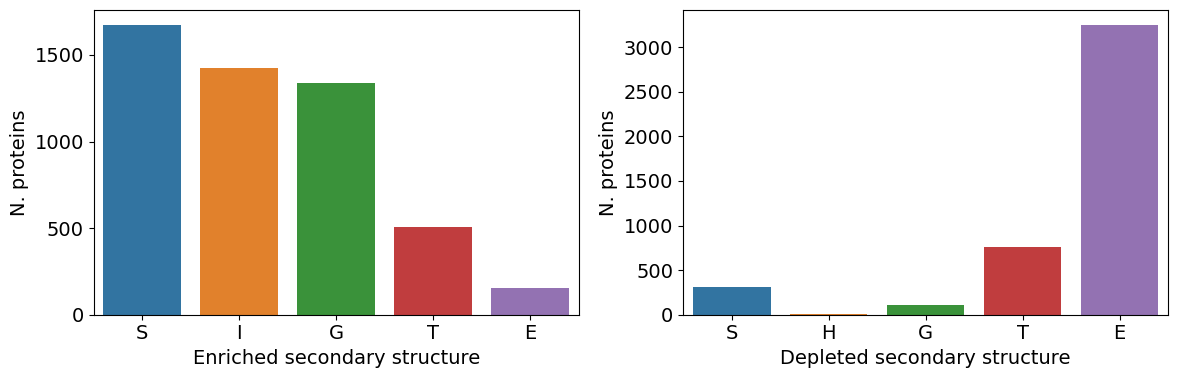

In [20]:
plt.figure(dpi=100, figsize=(12, 4))

plt.subplot(1, 2, 1)

sns.barplot(
    data = enriched_struct_count, x = 'struct', y = 'n_proteins',
    order = enriched_struct_count['struct'][
        enriched_struct_count['n_proteins'].sort_values(ascending=False).index
    ],
)
plt.xlabel('Enriched secondary structure')
plt.ylabel('N. proteins')

plt.subplot(1, 2, 2)
sns.barplot(
    data = depleted_struct_count, x = 'struct', y = 'n_proteins',
    order = depleted_struct_count['struct'][
        enriched_struct_count['n_proteins'].sort_values(ascending=False).index
    ]
)
plt.xlabel('Depleted secondary structure')
plt.ylabel('N. proteins')

plt.tight_layout()

struct_descr

In [21]:
enriched_and_depleted_counts = pd.concat(
    [enriched_struct_count.assign(set = 'enriched'),
     depleted_struct_count.assign(n_proteins = -depleted_struct_count['n_proteins']).assign(set = 'depleted')],
    ignore_index=True
)

In [22]:
enriched_and_depleted_counts = pd.merge(
    enriched_struct_count,
    depleted_struct_count,
    on = 'struct',
    suffixes=('_enriched', '_depleted'),
    how = 'outer'
).fillna(0)

enriched_and_depleted_counts['n_proteins_enriched'] = enriched_and_depleted_counts['n_proteins_enriched'].astype('uint16')
enriched_and_depleted_counts['n_proteins_depleted'] = -enriched_and_depleted_counts['n_proteins_depleted'].astype('int16')

enriched_and_depleted_counts

,struct,n_proteins_enriched,n_proteins_depleted
0,E,157,-3254
1,G,1336,-104
2,I,1425,0
3,S,1676,-315
4,T,505,-754
5,H,0,-8


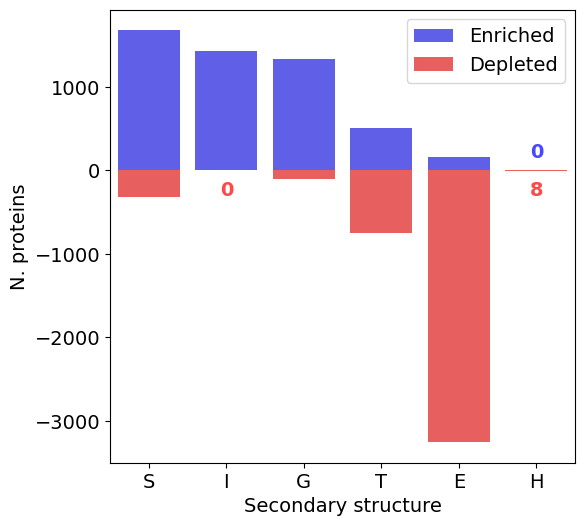

In [50]:
plt.figure(dpi=100, figsize=(6, 6))

palette = sns.color_palette('bwr')

g_e = sns.barplot(
    data = enriched_and_depleted_counts,
    x = 'struct',
    y = 'n_proteins_enriched',
    color = palette[0],
    order = list('SIGTEH'),
    label = 'Enriched'
)

g_d = sns.barplot(
    data = enriched_and_depleted_counts,
    x = 'struct',
    y = 'n_proteins_depleted',
    color = palette[-1],
    order = list('SIGTEH'),
    label = 'Depleted'
)

# for container in g_e.containers:
#     g_e.bar_label(container)
    
# for container in g_d.containers:
#     g_d.bar_label(container)

plt.legend()
    
plt.xlabel('Secondary structure')
plt.ylabel('N. proteins')

plt.annotate('0', xy=(0.92, -300), color=palette[-1], fontweight='bold')
plt.annotate('8', xy=(4.92, -300), color=palette[-1], fontweight='bold')
plt.annotate('0', xy=(4.92, 150),  color=palette[0], fontweight='bold')

plt.savefig('signif_secondary_structure_counts.pdf')

In [24]:
enriched_and_depleted_counts.to_csv('att_secondary_struct_enriched_and_depleted_counts.csv', index=False)